Load in Data from .mat files

In [30]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from processing_utils.feature_data_from_mat import load_subject_high_gamma

In [31]:
hg_trace, hg_map, phon_labels = load_subject_high_gamma('S14', sig_channel=False, zscore=False)

(149, 200, 128)
(149, 8, 16, 200)
(149, 3)


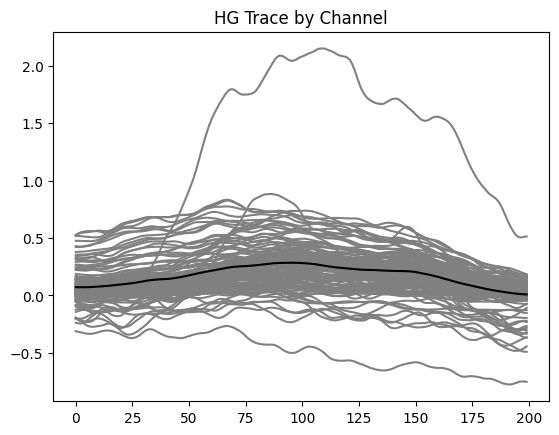

In [32]:
print(hg_trace.shape)
print(hg_map.shape)
print(phon_labels.shape)

plt.figure()
plt.plot(np.mean(hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Process data for use with 1/3 D CNN Bidirectional LSTM seq2seq

In [33]:
# imports
from processing_utils.sequence_processing import pad_sequence_teacher_forcing

In [34]:
# parameters
n_output = 10

In [35]:
X = hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X = hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X_prior, y, prior_labels, seq_labels = pad_sequence_teacher_forcing(phon_labels, n_output)  # first 2 outputs one-hot encoded

In [36]:
print(X.shape, X_prior.shape, y.shape, prior_labels.shape, seq_labels.shape)

(149, 200, 128) (149, 3, 10) (149, 3, 10) (149, 3) (149, 3)


Build 1D CNN Bidirectional LSTM seq2seq Model

In [37]:
# imports
from seq2seq_models.rnn_models import (lstm_1Dcnn_model, gru_1Dcnn_model, 
                                       lstm_3Dcnn_model, gru_3Dcnn_model)


In [38]:
# parameters

# 1D CNN
n_input_time = X.shape[1]
n_input_channel = X.shape[2]
filter_size = 10

# 3D CNN
# n_input_channel = [X.shape[1], X.shape[2]]
# n_input_time = X.shape[3]
# filter_size = 2

n_filters = 50
n_units = 200
reg_lambda = 1e-6
dropout = 0.0
bidir = True

In [39]:
train_model, inf_enc, inf_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir, dropout=dropout)
# train_model, inf_enc, inf_dec = lstm_3Dcnn_model(n_input_time, n_input_x, n_input_y, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = gru_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)
# train_model, inf_enc, inf_dec = gru_3Dcnn_model(n_input_time, n_input_x, n_input_y, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)

In [ ]:
print(train_model.summary())
print(train_model.layers[-1].summary())
print(inf_enc.summary())
print(inf_enc.layers[-1].summary())
print(inf_dec.summary())

### Hyperparameter Optimization

In [ ]:
import keras_tuner as kt
from sklearn.model_selection import ShuffleSplit
from train.optimize import encDecHyperModel, encDecTuner

In [ ]:
data_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
train_idx, test_idx = next(data_split.split(X))
X_train, X_test = X[train_idx], X[test_idx]
X_prior_train, X_prior_test = X_prior[train_idx], X_prior[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [ ]:
optim_trials = 100
hyper_model = encDecHyperModel(lstm_1Dcnn_model, n_input_time, n_input_channel, n_output)
rnn_optimizer = encDecTuner(hypermodel=hyper_model,
                            oracle=kt.oracles.RandomSearchOracle(objective=kt.Objective('val_accuracy', direction='max'),
                                                                 max_trials=optim_trials),
                            directory='data/rnn_tuning', project_name='S14_1Dcnn_LSTM')

In [ ]:
rnn_optimizer.search(X_train, X_prior_train, y_train, epochs=800)

In [ ]:
rnn_optimizer.results_summary()

In [ ]:
optim_params = rnn_optimizer.get_best_hyperparameters(num_trials=10)[0].values
print(optim_params)

In [ ]:
from keras.optimizers import Adam
optim_model, optim_enc, optim_dec = lstm_1Dcnn_model(n_input_time, n_input_channel,
                                                     n_output, n_filters=optim_params['num_filts'],
                                                     filter_size=10, n_units=optim_params['rnn_units'],
                                                     reg_lambda=optim_params['reg_lambda'])

learning_rate = 5e-4
optim_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from train.train import train_seq2seq, decode_seq2seq

_, histories = train_seq2seq(optim_model, X_train, X_prior_train, y_train, epochs=800)


In [ ]:
from sklearn.metrics import balanced_accuracy_score

y_pred_optim, y_test_optim = decode_seq2seq(optim_enc, optim_dec, X_test, y_test)
print(f'Hyperparameter Optimized Balanced Accuracy: {balanced_accuracy_score(y_test_optim, y_pred_optim)}')

### Train Model

In [40]:
# imports
import time
import tensorflow as tf
from keras.optimizers import Adam
from train.train import train_seq2seq_kfold

In [41]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [42]:
# parameters
num_folds = 10
num_reps = 1
batch_size = 200
epochs = 800
learning_rate = 5e-5

train_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
start = time.time()
with tf.device('/device:GPU:0'):
    histories, y_pred_all, y_test_all = train_seq2seq_kfold(train_model, inf_enc, inf_dec, X, X_prior, y,
                                                            num_folds=num_folds, num_reps=num_reps,
                                                            batch_size=batch_size, 
                                                            epochs=epochs, early_stop=False)
end = time.time()


===== Fold 1 =====
Epoch 1/800
1/1 [==============================] - 4s 4s/step - loss: 2.3201 - accuracy: 0.1045 - val_loss: 2.3112 - val_accuracy: 0.1778
Epoch 2/800
1/1 [==============================] - 0s 68ms/step - loss: 2.3165 - accuracy: 0.1020 - val_loss: 2.3069 - val_accuracy: 0.2000
Epoch 3/800
1/1 [==============================] - 0s 72ms/step - loss: 2.3116 - accuracy: 0.1070 - val_loss: 2.3027 - val_accuracy: 0.2222
Epoch 4/800
1/1 [==============================] - 0s 60ms/step - loss: 2.3076 - accuracy: 0.1119 - val_loss: 2.2986 - val_accuracy: 0.2222
Epoch 5/800
1/1 [==============================] - 0s 55ms/step - loss: 2.3033 - accuracy: 0.1070 - val_loss: 2.2946 - val_accuracy: 0.2222
Epoch 6/800
1/1 [==============================] - 0s 54ms/step - loss: 2.3005 - accuracy: 0.1045 - val_loss: 2.2907 - val_accuracy: 0.2222
Epoch 7/800
1/1 [==============================] - 0s 54ms/step - loss: 2.2959 - accuracy: 0.1045 - val_loss: 2.2869 - val_accuracy: 0.2222
Epo

In [44]:
print(f'Time to train {num_folds} folds: {end-start} seconds')

Time to train 10 folds: 464.54320549964905 seconds


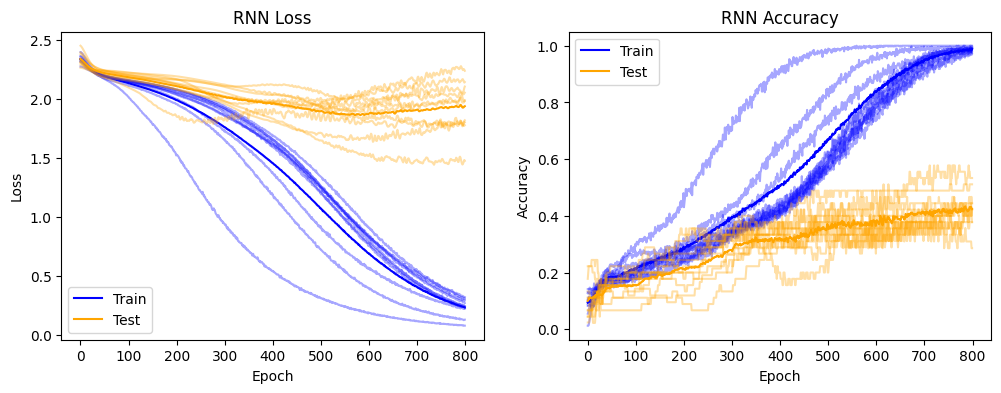

In [45]:
from visualization.plot_model_performance import extend_history_lists

histories = extend_history_lists(histories, epochs=epochs)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories['val_loss'], axis=0), color='orange', label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories['val_accuracy'], axis=0), color='orange', label='Test')
# ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()

In [46]:
from sklearn.metrics import balanced_accuracy_score

print(f'Balanced Accuracy: {balanced_accuracy_score(y_test_all, y_pred_all)}')

Balanced Accuracy: 0.3730257897649395


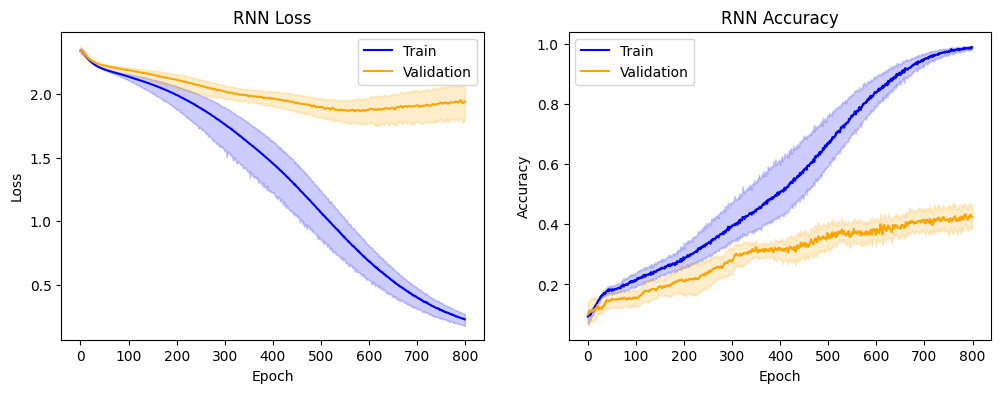

In [47]:
from visualization.plot_model_performance import plot_accuracy_loss

plot_accuracy_loss(histories, epochs=epochs)